# Setup Training and Validaiton Datasets


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [11]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

# Step 1: Extract images from the ZIP file
zip_path = 'drive/MyDrive/DL/train_shuffle.zip'
extract_folder = 'images'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 2: Read CSV file
csv_path = 'drive/MyDrive/DL/train_data.csv'
df = pd.read_csv(csv_path)

# Step 3: Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Step 4: Create folder structure for training set
dataset_root = 'dataset'
train_root = os.path.join(dataset_root, 'train')
os.makedirs(train_root, exist_ok=True)

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc='Creating Training Folder Structure'):
    image_path = os.path.join(extract_folder, "train_shuffle", row['image'])
    superclass = str(row['superclass_index'])
    subclass = str(row['subclass_index'])

    # Create superclass folder if not exists
    superclass_folder = os.path.join(train_root, superclass)
    os.makedirs(superclass_folder, exist_ok=True)

    # Create subclass folder if not exists
    subclass_folder = os.path.join(superclass_folder, subclass)
    os.makedirs(subclass_folder, exist_ok=True)

    # Move the image to the subclass folder
    shutil.move(image_path, subclass_folder)

# Step 5: Create folder structure for validation set
val_root = os.path.join(dataset_root, 'val')
os.makedirs(val_root, exist_ok=True)

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc='Creating Validation Folder Structure'):
    image_path = os.path.join(extract_folder, "train_shuffle", row['image'])
    superclass = str(row['superclass_index'])
    subclass = str(row['subclass_index'])

    # Create superclass folder if not exists
    superclass_folder = os.path.join(val_root, superclass)
    os.makedirs(superclass_folder, exist_ok=True)

    # Create subclass folder if not exists
    subclass_folder = os.path.join(superclass_folder, subclass)
    os.makedirs(subclass_folder, exist_ok=True)

    # Move the image to the subclass folder
    shutil.move(image_path, subclass_folder)

print("Folder structure creation complete.")

Creating Validation Folder Structure: 100%|██████████| 633/633 [00:00<00:00, 7281.52it/s]

Folder structure creation complete.


# Visualize Model - No Need to run this

In [14]:
from torchvision.transforms import v2

data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

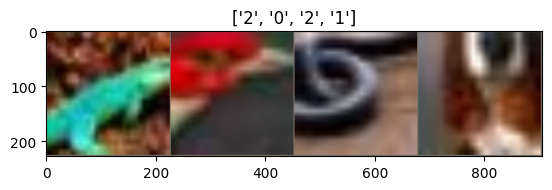

In [19]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

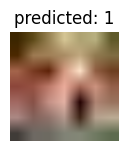

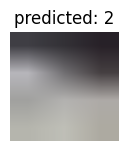

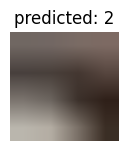

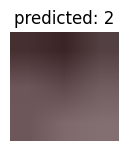

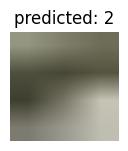

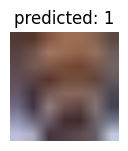

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

# Train Genereralized

In [60]:
#image folder but return both class and subclass label
class CustomImageFolder(datasets.ImageFolder):
  def __getitem__(self, index):
    image,_ = super().__getitem__(index)
    path, _ = self.samples[index]

    class_label = int(path.split(os.sep)[-3])  # Assuming the class label is the second-to-last directory
    subclass_label = int(path.split(os.sep)[-2])  # Assuming the subclass label is the last directory

    return image, (class_label, subclass_label)

In [61]:
def get_dataloaders(batch_size, num_workers=2, img_size=(224,224)):
  data_transforms = {
      'train': v2.Compose([
          v2.ToImage(),
          v2.RandomResizedCrop(size=img_size, antialias=True),  # Or Resize(antialias=True)
          v2.RandomHorizontalFlip(),
          v2.ToDtype(torch.float32, scale=True),
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]),
      'val': v2.Compose([
          v2.ToImage(),
          v2.RandomResizedCrop(size=img_size, antialias=True),  # Or Resize(antialias=True)
          v2.ToDtype(torch.float32, scale=True),
          v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]),
  }

  data_dir = 'dataset'
  image_datasets = {x: CustomImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  return dataloaders, dataset_sizes


In [74]:
class CustomImageClassifier(nn.Module):
  def __init__(self, base_model, hidden_size, num_superclasses, num_subclasses):
    super(CustomImageClassifier, self).__init__()

    #Remove the existing classifier layer, If the model is ResNet, handle its sequential structure
    if isinstance(base_model, ResNetForImageClassification):
      base_model.classifier = nn.Sequential(*list(base_model.classifier.children())[:-1])
    else:
      base_model.classifier = nn.Identity()

    # Add your custom classifiers
    self.classifier_subclass = nn.Linear(hidden_size, num_subclasses)
    self.classifier_superclass = nn.Linear(hidden_size, num_superclasses)

    # Store the base model
    self.base_model = base_model

  def forward(self, pixel_values, labels=None, **kwargs):
    output = self.base_model(pixel_values=pixel_values, labels=labels, **kwargs)

    # Apply the subclass and superclass classifiers
    logits_subclass = self.classifier_subclass(output.logits)
    logits_superclass = self.classifier_superclass(output.logits)

    return {'logits_subclass': logits_subclass, 'logits_superclass': logits_superclass}


In [92]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification, ViTImageProcessor, ViTForImageClassification, AutoImageProcessor, ResNetForImageClassification,ConvNextV2ForImageClassification,BeitForImageClassification,AutoModelForImageClassification


def get_model(model_name, fine_tune, num_classes=3, num_subclasses=87):
  if model_name == "vit":
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "convnext":
    model = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-224-22k")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "convnextv2-tiny":
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-1k-224")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "convnextv2":
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-base-22k-224")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "convnextv2-22k-tiny":
    model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-22k-224")
    model = CustomImageClassifier(model, model.classifier.in_features, num_classes, num_subclasses)
  elif model_name == "resnet50":
    model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
    model = CustomImageClassifier(model, model.classifier[-1].in_features, num_classes, num_subclasses)
  elif model_name == "deit-tiny":
    model = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "deit":
    model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)
  elif model_name == "beit":
    model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
    model = CustomImageClassifier(model, model.config.hidden_size, num_classes, num_subclasses)


  if fine_tune:
    # Freeze all layers except the new classifier head
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier_subclass.parameters():
        param.requires_grad = True
    for param in model.classifier_superclass.parameters():
        param.requires_grad = True

  return model



In [72]:
def train_model_v2(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, alpha, beta):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                epoch_since = time.time()
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects_subclass = 0
                running_corrects_superclass = 0

                # Iterate over data.
                for inputs, (super_labels, sub_labels) in dataloaders[phase]:
                    size = inputs.size(0)
                    inputs = inputs.to(device)
                    super_labels = super_labels.to(device)
                    sub_labels = sub_labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        outputs_subclass = outputs['logits_subclass']
                        outputs_superclass = outputs['logits_superclass']
                        _, preds_subclass = torch.max(outputs_subclass, 1)
                        _, preds_superclass = torch.max(outputs_superclass, 1)

                        loss_subclass = criterion(outputs_subclass, sub_labels)
                        loss_superclass = criterion(outputs_superclass, super_labels)

                        # Combine the subclass and superclass losses as needed
                        loss = alpha * loss_subclass + beta * loss_superclass

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * size
                    running_corrects_subclass += torch.sum(preds_subclass == sub_labels.data)
                    running_corrects_superclass += torch.sum(preds_superclass == super_labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc_subclass = running_corrects_subclass.double() / dataset_sizes[phase]
                epoch_acc_superclass = running_corrects_superclass.double() / dataset_sizes[phase]
                epoch_time_elapsed = time.time() - epoch_since

                print(f'{phase} Loss: {epoch_loss:.4f} Acc (Superclass): {epoch_acc_superclass:.4f} Acc (Subclass): {epoch_acc_subclass:.4f} Time: {epoch_time_elapsed % 60:.0f}s')

                # deep copy the model
                if phase == 'val' and epoch_acc_subclass + epoch_acc_superclass > best_acc:
                    best_acc = epoch_acc_subclass + epoch_acc_superclass
                    torch.save(model.state_dict(), best_model_params_path)


        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [65]:
def train(params):
  num_workers = params["num_workers"] if "num_workers" in params else 2
  num_classes = params["num_classes"] if "num_classes" in params else 3
  learning_rate = params["learning_rate"] if "learning_rate" in params else 0.001
  momentum = params["momentum"] if "momentum" in params else 0.9
  step_size = params["step_size"] if "step_size" in params else 7
  gamma = params["gamma"] if "gamma" in params else 0.1
  alpha = params["alpha"] if "alpha" in params else 0.5
  beta = params["beta"] if "beta" in params else 0.5


  dataloaders, dataset_sizes = get_dataloaders(params["batch_size"],num_workers=num_workers)
  model = get_model(params["model_name"], params["fine_tune"], num_classes=num_classes)

  model.to(device)

  if params["loss"] == "cross_entropy":
    criterion = nn.CrossEntropyLoss()

  if params["optimizer"] == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  if params["scheduler"] == "step_lr":
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  model = train_model_v2(model, criterion, optimizer, scheduler, params["num_epochs"], dataloaders, dataset_sizes, alpha, beta)



# Resnet50 as Feature Extractor

In [75]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"resnet50", "batch_size":32, "fine_tune":True}
train(params)


Epoch 0/9
----------
train Loss: 2.7486 Acc (Superclass): 0.5567 Acc (Subclass): 0.0178 Time: 25s
val Loss: 2.7206 Acc (Superclass): 0.6051 Acc (Subclass): 0.0221 Time: 3s
Epoch 1/9
----------
train Loss: 2.6966 Acc (Superclass): 0.6254 Acc (Subclass): 0.0272 Time: 23s
val Loss: 2.6721 Acc (Superclass): 0.6935 Acc (Subclass): 0.0237 Time: 3s
Epoch 2/9
----------
train Loss: 2.6591 Acc (Superclass): 0.6506 Acc (Subclass): 0.0385 Time: 23s
val Loss: 2.6358 Acc (Superclass): 0.6856 Acc (Subclass): 0.0379 Time: 3s
Epoch 3/9
----------
train Loss: 2.6277 Acc (Superclass): 0.6738 Acc (Subclass): 0.0508 Time: 23s
val Loss: 2.6190 Acc (Superclass): 0.6682 Acc (Subclass): 0.0332 Time: 3s
Epoch 4/9
----------
train Loss: 2.6057 Acc (Superclass): 0.6797 Acc (Subclass): 0.0613 Time: 24s
val Loss: 2.5863 Acc (Superclass): 0.7220 Acc (Subclass): 0.0585 Time: 3s
Epoch 5/9
----------
train Loss: 2.5890 Acc (Superclass): 0.6799 Acc (Subclass): 0.0705 Time: 22s
val Loss: 2.5649 Acc (Superclass): 0.6840 

# Fine Tune Resnet 50

In [77]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"resnet50", "batch_size":32, "fine_tune":False}
train(params)

Epoch 0/9
----------
train Loss: 2.7554 Acc (Superclass): 0.5061 Acc (Subclass): 0.0151 Time: 17s
val Loss: 2.7115 Acc (Superclass): 0.6414 Acc (Subclass): 0.0253 Time: 3s
Epoch 1/9
----------
train Loss: 2.6849 Acc (Superclass): 0.6398 Acc (Subclass): 0.0302 Time: 4s
val Loss: 2.6440 Acc (Superclass): 0.6793 Acc (Subclass): 0.0284 Time: 3s
Epoch 2/9
----------
train Loss: 2.6242 Acc (Superclass): 0.6776 Acc (Subclass): 0.0476 Time: 4s
val Loss: 2.6051 Acc (Superclass): 0.6983 Acc (Subclass): 0.0363 Time: 3s
Epoch 3/9
----------
train Loss: 2.5737 Acc (Superclass): 0.7079 Acc (Subclass): 0.0585 Time: 4s
val Loss: 2.5484 Acc (Superclass): 0.7235 Acc (Subclass): 0.0742 Time: 3s
Epoch 4/9
----------
train Loss: 2.5246 Acc (Superclass): 0.7395 Acc (Subclass): 0.0752 Time: 4s
val Loss: 2.5056 Acc (Superclass): 0.7757 Acc (Subclass): 0.0853 Time: 3s
Epoch 5/9
----------
train Loss: 2.4918 Acc (Superclass): 0.7534 Acc (Subclass): 0.0847 Time: 4s
val Loss: 2.4563 Acc (Superclass): 0.7725 Acc (

# ConvnextV2 Tiny As Feature Extractor

In [76]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2-tiny", "batch_size":32, "fine_tune":True}
train(params)

Epoch 0/9
----------
train Loss: 2.4973 Acc (Superclass): 0.7954 Acc (Subclass): 0.0501 Time: 39s
val Loss: 2.2989 Acc (Superclass): 0.8863 Acc (Subclass): 0.1438 Time: 5s
Epoch 1/9
----------
train Loss: 2.2237 Acc (Superclass): 0.8668 Acc (Subclass): 0.1895 Time: 37s
val Loss: 2.1457 Acc (Superclass): 0.8863 Acc (Subclass): 0.2480 Time: 4s
Epoch 2/9
----------
train Loss: 2.0624 Acc (Superclass): 0.8849 Acc (Subclass): 0.2900 Time: 37s
val Loss: 1.9978 Acc (Superclass): 0.8815 Acc (Subclass): 0.3096 Time: 5s
Epoch 3/9
----------
train Loss: 1.9376 Acc (Superclass): 0.8930 Acc (Subclass): 0.3445 Time: 37s
val Loss: 1.8789 Acc (Superclass): 0.8863 Acc (Subclass): 0.3649 Time: 5s
Epoch 4/9
----------
train Loss: 1.8306 Acc (Superclass): 0.8952 Acc (Subclass): 0.3711 Time: 37s
val Loss: 1.7816 Acc (Superclass): 0.8894 Acc (Subclass): 0.3776 Time: 4s
Epoch 5/9
----------
train Loss: 1.7434 Acc (Superclass): 0.8965 Acc (Subclass): 0.3916 Time: 37s
val Loss: 1.7131 Acc (Superclass): 0.9068 

# Convnext as feature Extractor

In [78]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnext", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 2.3680 Acc (Superclass): 0.8532 Acc (Subclass): 0.0923 Time: 18s
val Loss: 2.0966 Acc (Superclass): 0.9431 Acc (Subclass): 0.2148 Time: 9s
Epoch 1/9
----------
train Loss: 1.9728 Acc (Superclass): 0.9221 Acc (Subclass): 0.3138 Time: 16s
val Loss: 1.8542 Acc (Superclass): 0.9273 Acc (Subclass): 0.3823 Time: 9s
Epoch 2/9
----------
train Loss: 1.7352 Acc (Superclass): 0.9309 Acc (Subclass): 0.4189 Time: 16s
val Loss: 1.6376 Acc (Superclass): 0.9384 Acc (Subclass): 0.4502 Time: 9s
Epoch 3/9
----------
train Loss: 1.5568 Acc (Superclass): 0.9341 Acc (Subclass): 0.4711 Time: 16s
val Loss: 1.4824 Acc (Superclass): 0.9368 Acc (Subclass): 0.4660 Time: 9s
Epoch 4/9
----------
train Loss: 1.4091 Acc (Superclass): 0.9358 Acc (Subclass): 0.5198 Time: 16s
val Loss: 1.3811 Acc (Superclass): 0.9242 Acc (Subclass): 0.5134 Time: 9s
Epoch 5/9
----------
train Loss: 1.3156 Acc (Superclass): 0.9336 Acc (Subclass): 0.5374 Time: 16s
val Loss: 1.2664 Acc (Superclass): 0.9447 

# VIT As Feature Extractor

In [79]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"vit", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 2.2821 Acc (Superclass): 0.8109 Acc (Subclass): 0.1194 Time: 17s
val Loss: 1.9487 Acc (Superclass): 0.8910 Acc (Subclass): 0.2449 Time: 9s
Epoch 1/9
----------
train Loss: 1.7781 Acc (Superclass): 0.8817 Acc (Subclass): 0.3236 Time: 16s
val Loss: 1.5803 Acc (Superclass): 0.9021 Acc (Subclass): 0.3855 Time: 9s
Epoch 2/9
----------
train Loss: 1.5078 Acc (Superclass): 0.8924 Acc (Subclass): 0.4261 Time: 16s
val Loss: 1.4149 Acc (Superclass): 0.9163 Acc (Subclass): 0.4329 Time: 9s
Epoch 3/9
----------
train Loss: 1.3312 Acc (Superclass): 0.9077 Acc (Subclass): 0.4811 Time: 17s
val Loss: 1.2756 Acc (Superclass): 0.9163 Acc (Subclass): 0.4882 Time: 9s
Epoch 4/9
----------
train Loss: 1.2240 Acc (Superclass): 0.9026 Acc (Subclass): 0.5233 Time: 16s
val Loss: 1.2074 Acc (Superclass): 0.9131 Acc (Subclass): 0.5071 Time: 9s
Epoch 5/9
----------
train Loss: 1.1198 Acc (Superclass): 0.9105 Acc (Subclass): 0.5526 Time: 17s
val Loss: 1.1448 Acc (Superclass): 0.9194 

# Convnextv2 as feature extractor

In [88]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/355M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 1.9888 Acc (Superclass): 0.8954 Acc (Subclass): 0.2415 Time: 33s
val Loss: 1.5050 Acc (Superclass): 0.9321 Acc (Subclass): 0.4487 Time: 11s
Epoch 1/9
----------
train Loss: 1.3003 Acc (Superclass): 0.9369 Acc (Subclass): 0.5112 Time: 34s
val Loss: 1.1399 Acc (Superclass): 0.9289 Acc (Subclass): 0.5434 Time: 11s
Epoch 2/9
----------
train Loss: 1.0158 Acc (Superclass): 0.9430 Acc (Subclass): 0.5976 Time: 32s
val Loss: 0.9306 Acc (Superclass): 0.9463 Acc (Subclass): 0.6288 Time: 11s
Epoch 3/9
----------
train Loss: 0.8807 Acc (Superclass): 0.9429 Acc (Subclass): 0.6456 Time: 32s
val Loss: 0.8131 Acc (Superclass): 0.9558 Acc (Subclass): 0.6603 Time: 11s
Epoch 4/9
----------
train Loss: 0.7875 Acc (Superclass): 0.9480 Acc (Subclass): 0.6701 Time: 32s
val Loss: 0.7629 Acc (Superclass): 0.9415 Acc (Subclass): 0.6872 Time: 11s
Epoch 5/9
----------
train Loss: 0.7535 Acc (Superclass): 0.9445 Acc (Subclass): 0.6875 Time: 32s
val Loss: 0.7496 Acc (Superclass): 0.

# Beit as Feature Extractor

In [83]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"beit", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 2.5376 Acc (Superclass): 0.6731 Acc (Subclass): 0.0562 Time: 21s
val Loss: 2.3402 Acc (Superclass): 0.7883 Acc (Subclass): 0.1122 Time: 9s
Epoch 1/9
----------
train Loss: 2.2835 Acc (Superclass): 0.7551 Acc (Subclass): 0.1271 Time: 20s
val Loss: 2.1956 Acc (Superclass): 0.7725 Acc (Subclass): 0.1659 Time: 9s
Epoch 2/9
----------
train Loss: 2.1539 Acc (Superclass): 0.7750 Acc (Subclass): 0.1803 Time: 20s
val Loss: 2.0837 Acc (Superclass): 0.8041 Acc (Subclass): 0.1864 Time: 9s
Epoch 3/9
----------
train Loss: 2.0654 Acc (Superclass): 0.7817 Acc (Subclass): 0.2224 Time: 19s
val Loss: 2.0031 Acc (Superclass): 0.8104 Acc (Subclass): 0.2196 Time: 9s
Epoch 4/9
----------
train Loss: 1.9918 Acc (Superclass): 0.7938 Acc (Subclass): 0.2394 Time: 20s
val Loss: 1.9618 Acc (Superclass): 0.8167 Acc (Subclass): 0.2322 Time: 9s
Epoch 5/9
----------
train Loss: 1.9329 Acc (Superclass): 0.7928 Acc (Subclass): 0.2623 Time: 20s
val Loss: 1.8934 Acc (Superclass): 0.8294 

# Deit Tiny as Feature Extractor

In [85]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"deit-tiny", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 2.4250 Acc (Superclass): 0.7718 Acc (Subclass): 0.0650 Time: 20s
val Loss: 2.1195 Acc (Superclass): 0.8547 Acc (Subclass): 0.1232 Time: 4s
Epoch 1/9
----------
train Loss: 1.9172 Acc (Superclass): 0.8661 Acc (Subclass): 0.2169 Time: 23s
val Loss: 1.7757 Acc (Superclass): 0.8768 Acc (Subclass): 0.2622 Time: 2s
Epoch 2/9
----------
train Loss: 1.6579 Acc (Superclass): 0.8712 Acc (Subclass): 0.3152 Time: 18s
val Loss: 1.5791 Acc (Superclass): 0.8784 Acc (Subclass): 0.3570 Time: 2s
Epoch 3/9
----------
train Loss: 1.4926 Acc (Superclass): 0.8775 Acc (Subclass): 0.3865 Time: 17s
val Loss: 1.4363 Acc (Superclass): 0.8894 Acc (Subclass): 0.3949 Time: 2s
Epoch 4/9
----------
train Loss: 1.3719 Acc (Superclass): 0.8792 Acc (Subclass): 0.4365 Time: 17s
val Loss: 1.3470 Acc (Superclass): 0.8815 Acc (Subclass): 0.4455 Time: 2s
Epoch 5/9
----------
train Loss: 1.2839 Acc (Superclass): 0.8836 Acc (Subclass): 0.4642 Time: 17s
val Loss: 1.2760 Acc (Superclass): 0.8752 

# Deit as Feature Extractor

In [90]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"deit", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 2.3186 Acc (Superclass): 0.8339 Acc (Subclass): 0.1141 Time: 17s
val Loss: 2.0635 Acc (Superclass): 0.9084 Acc (Subclass): 0.2401 Time: 9s
Epoch 1/9
----------
train Loss: 1.9083 Acc (Superclass): 0.9038 Acc (Subclass): 0.3226 Time: 17s
val Loss: 1.7696 Acc (Superclass): 0.9258 Acc (Subclass): 0.3949 Time: 9s
Epoch 2/9
----------
train Loss: 1.6622 Acc (Superclass): 0.9179 Acc (Subclass): 0.4168 Time: 17s
val Loss: 1.5689 Acc (Superclass): 0.9305 Acc (Subclass): 0.4408 Time: 9s
Epoch 3/9
----------
train Loss: 1.4882 Acc (Superclass): 0.9209 Acc (Subclass): 0.4744 Time: 17s
val Loss: 1.4106 Acc (Superclass): 0.9242 Acc (Subclass): 0.4961 Time: 9s
Epoch 4/9
----------
train Loss: 1.3509 Acc (Superclass): 0.9276 Acc (Subclass): 0.5191 Time: 17s
val Loss: 1.3188 Acc (Superclass): 0.9147 Acc (Subclass): 0.5213 Time: 9s
Epoch 5/9
----------
train Loss: 1.2532 Acc (Superclass): 0.9251 Acc (Subclass): 0.5546 Time: 16s
val Loss: 1.1948 Acc (Superclass): 0.9352 

# Convnextv2 22k tiny as feature extractor


In [93]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2-22k-tiny", "batch_size":32, "fine_tune":True}
train(params)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/115M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 2.1308 Acc (Superclass): 0.8481 Acc (Subclass): 0.1765 Time: 39s
val Loss: 1.6625 Acc (Superclass): 0.9021 Acc (Subclass): 0.3791 Time: 5s
Epoch 1/9
----------
train Loss: 1.4841 Acc (Superclass): 0.9086 Acc (Subclass): 0.4271 Time: 37s
val Loss: 1.3487 Acc (Superclass): 0.9084 Acc (Subclass): 0.4581 Time: 4s
Epoch 2/9
----------
train Loss: 1.1929 Acc (Superclass): 0.9156 Acc (Subclass): 0.5247 Time: 37s
val Loss: 1.2012 Acc (Superclass): 0.9036 Acc (Subclass): 0.5087 Time: 5s
Epoch 3/9
----------
train Loss: 1.0406 Acc (Superclass): 0.9195 Acc (Subclass): 0.5802 Time: 37s
val Loss: 1.0735 Acc (Superclass): 0.9163 Acc (Subclass): 0.5513 Time: 4s
Epoch 4/9
----------
train Loss: 0.9575 Acc (Superclass): 0.9172 Acc (Subclass): 0.6108 Time: 37s
val Loss: 0.9490 Acc (Superclass): 0.9242 Acc (Subclass): 0.6003 Time: 5s
Epoch 5/9
----------
train Loss: 0.8990 Acc (Superclass): 0.9211 Acc (Subclass): 0.6358 Time: 37s
val Loss: 0.8819 Acc (Superclass): 0.9384 

# Convnextv2 22k Tiny Fine Tune

In [ ]:
params = {"loss":"cross_entropy", "optimizer":"sgd", "scheduler":"step_lr", "num_epochs":10, "model_name":"convnextv2-22k-tiny", "batch_size":32, "fine_tune":False}
train(params)

Epoch 0/9
----------
train Loss: 2.7815 Acc (Superclass): 0.3632 Acc (Subclass): 0.0134 Time: 56s
val Loss: 2.7545 Acc (Superclass): 0.3618 Acc (Subclass): 0.0063 Time: 5s
Epoch 1/9
----------
train Loss: 2.7587 Acc (Superclass): 0.3674 Acc (Subclass): 0.0146 Time: 53s
val Loss: 2.7581 Acc (Superclass): 0.3618 Acc (Subclass): 0.0063 Time: 4s
Epoch 2/9
----------
train Loss: 2.7556 Acc (Superclass): 0.3726 Acc (Subclass): 0.0146 Time: 53s
val Loss: 2.7557 Acc (Superclass): 0.3618 Acc (Subclass): 0.0111 Time: 5s
Epoch 3/9
----------
train Loss: 2.7551 Acc (Superclass): 0.3721 Acc (Subclass): 0.0151 Time: 54s
val Loss: 2.7533 Acc (Superclass): 0.3618 Acc (Subclass): 0.0111 Time: 5s
Epoch 4/9
----------


# Hugging Face Sytle Training - Work in Progress


In [ ]:
! pip install accelerate -U


In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Specify your desired output directory
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,  # You may adjust these values based on your specific requirements
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=1e-3,
)
model = get_model("resnet50", True)
print(model)
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=None,  # Use default collation if not specified
    train_dataset=image_datasets['train'],
    eval_dataset=image_datasets['val'],
    tokenizer=AutoImageProcessor.from_pretrained("microsoft/resnet-50"),
)

# Start training
trainer.train()

# Save the trained model
trainer.save_model("./output_model")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

AttributeError: ignored